# NWA suntans: enstrophy low vs high, maps

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from xhistogram.xarray import histogram

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    #cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [3]:
_, grd = nwa.load_surf()
Ac = nwa.get_Ac()

zarr = os.path.join(nwa.suntans_dir, "suntans_2km_surf_gradients")
ds = xr.open_zarr(zarr)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")
ds_low = xr.open_zarr(zarr)

f = pin.geo.coriolis(ds.yv)

# focus on enstrophy for now
ds["vorticity"] = (ds["dvcdx"] - ds["ducdy"])/f
ds_low["vorticity"] = (ds_low["dvcdx"] - ds_low["ducdy"])/f

ds = ds[["vorticity"]].persist()
ds_low = ds_low[["vorticity"]].persist()

---
## histograms

In [7]:
# max is 1e-16
#error = np.abs(ds["ke_total"] - ds["ke_mean"] - ds["ke_low"] - ds["ke_high"])
#error.plot.hist(bins=bins, color="k")

In [17]:
bins = np.arange(-2, 2., .05)
hkwargs = dict(bins=bins, bin_dim_suffix='', keep_coords=True)

In [19]:
h = histogram(ds["vorticity"], dim=["time"], **hkwargs).persist()
h_global = histogram(ds["vorticity"], **hkwargs).persist()

In [20]:
h_low = histogram(ds_low["vorticity"], dim=["time"], **hkwargs).persist()
h_low_global = histogram(ds_low["vorticity"], **hkwargs).persist()

In [21]:
#histogram?

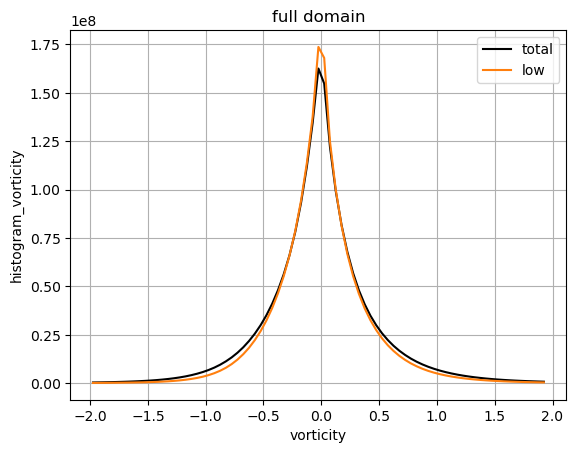

In [23]:
fig, ax = plt.subplots(1,1)

h_global.plot(ax=ax, color="k", label="total")
h_low_global.plot(ax=ax, color=dcolors[1], label="low")

ax.legend()
#ax.set_yscale("log")
ax.set_title("full domain")
ax.grid()

In [25]:
_h = nwa.zoom(h, nwa.area_cp).sum("Nc")
_h_low = nwa.zoom(h_low, nwa.area_cp).sum("Nc")

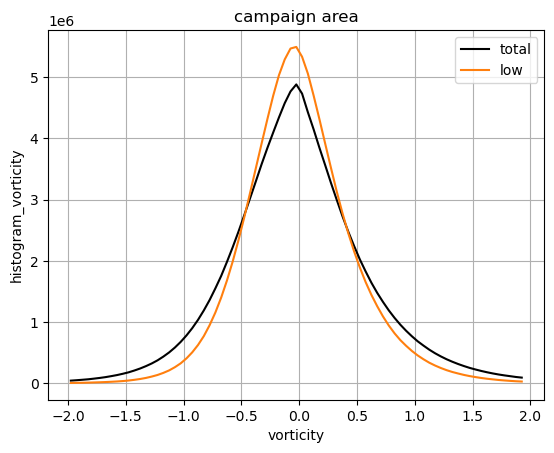

In [26]:
fig, ax = plt.subplots(1,1)

_h.plot(ax=ax, color="k", label="total")
_h_low.plot(ax=ax, color=dcolors[1], label="low")

ax.legend()
#ax.set_yscale("log")
ax.set_title("campaign area")
ax.grid()

### compute skewness

In [37]:
def skewness(h, dim="vorticity"):
    N = h.sum(dim)
    mean = h.sum(dim)/N
    std = np.sqrt( (h*(h.vorticity-mean)**2 ).sum(dim)/N )
    sk = (h*((h.vorticity-mean)/std)**3).sum(dim)/N
    return sk, std, mean

sk, std, mean = skewness(_h)

In [38]:
sk.compute(), std.compute(), mean.compute()

(<xarray.DataArray ()>
 array(-1.27624456),
 <xarray.DataArray ()>
 array(1.16603624),
 <xarray.DataArray 'histogram_vorticity' ()>
 array(1.))

## time averaged enstrophy

In [50]:
ds["vorticity2_mean_full"] = (ds["vorticity"]**2).mean("time").persist()
ds_low["vorticity2_mean_full"] = (ds_low["vorticity"]**2).mean("time").persist()

t0 = "2013/12/01"
ds["vorticity2_mean"] = (ds["vorticity"]**2).sel(time=slice(t0,None)).mean("time").persist()
ds_low["vorticity2_mean"] = (ds_low["vorticity"]**2).sel(time=slice(t0,None)).mean("time").persist()

In [57]:
nwa.zoom(da, nwa.bounds[zoom])

<xarray.DataArray (Nc: 195905)>
dask.array<where, shape=(195905,), dtype=float64, chunksize=(2000,), chunktype=numpy.ndarray>
Coordinates:
    dv       (Nc) float64 dask.array<chunksize=(1390,), meta=np.ndarray>
    nfaces   (Nc) int32 dask.array<chunksize=(1390,), meta=np.ndarray>
    xv       (Nc) float64 dask.array<chunksize=(1390,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(1390,), meta=np.ndarray>
Dimensions without coordinates: Nc

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


TypeError: 'str' object is not callable

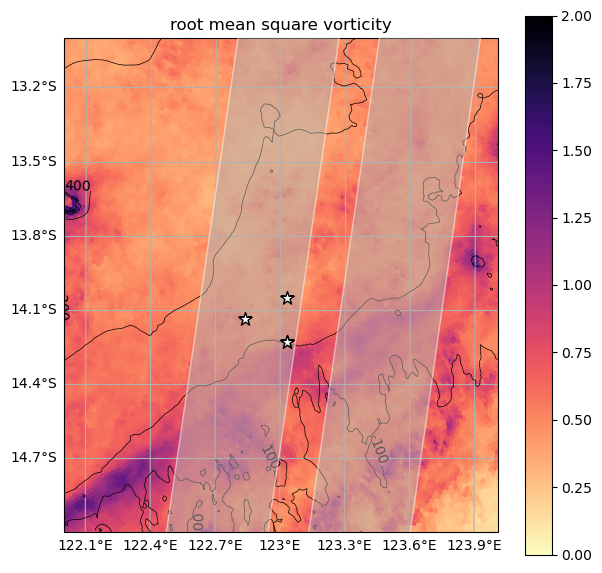

In [75]:
da = np.sqrt(ds["vorticity2_mean"])

for zoom in ["cp", "cp_large", "large"]:
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
    nwa.plot_moorings(ax)
    _, _, poly, cbar = grd.suntans.plotcelldata(da, vmin=0., vmax=2., cmap='magma_r', crs=crs)
    ax.set_title(f"root mean square vorticity")
    print(f"Spatial average = {float(spatial_average(da, Ac, area=zoom)):.2f}")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

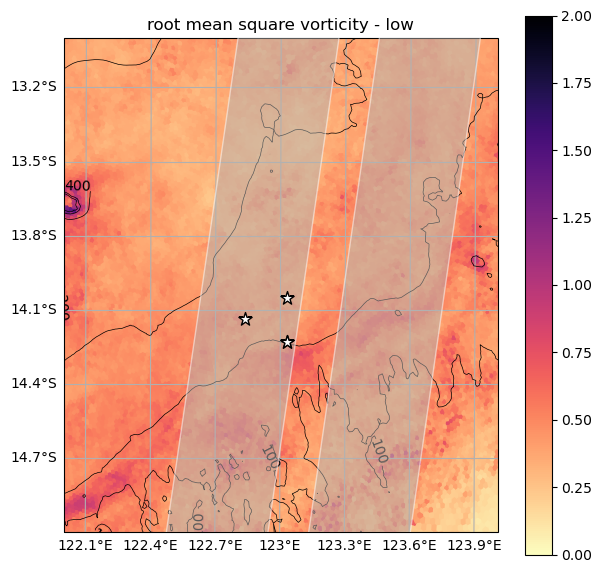

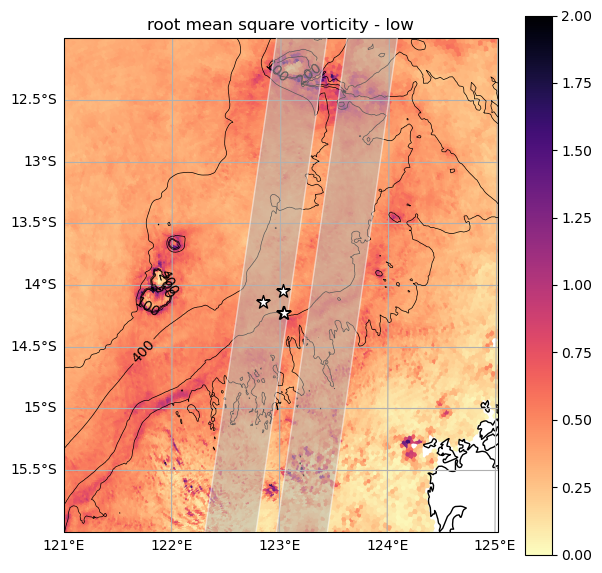

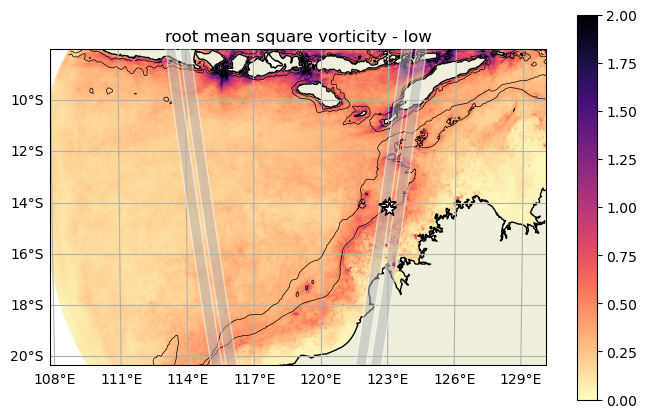

In [52]:
da = np.sqrt(ds_low["vorticity2_mean"])

for zoom in ["cp", "cp_large", "large"]:
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
    nwa.plot_moorings(ax)
    _, _, poly, cbar = grd.suntans.plotcelldata(da, vmin=0., vmax=2., cmap='magma_r', crs=crs)
    ax.set_title(f"root mean square vorticity - low")

In [ ]:
### ratio low to high


### same but ratio full time period over data past transient phase

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

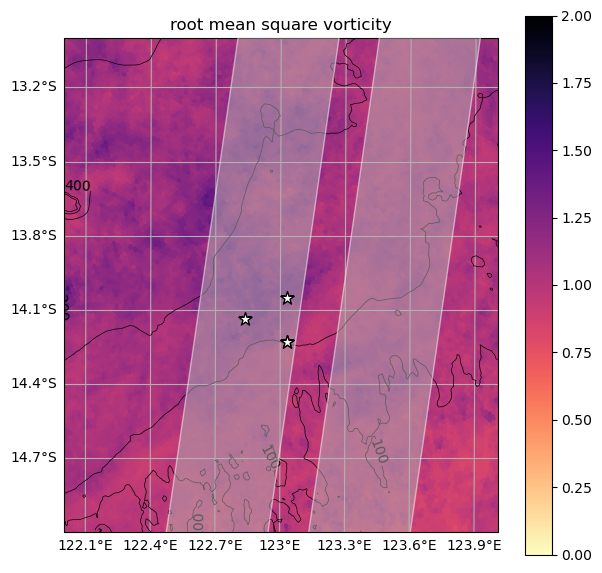

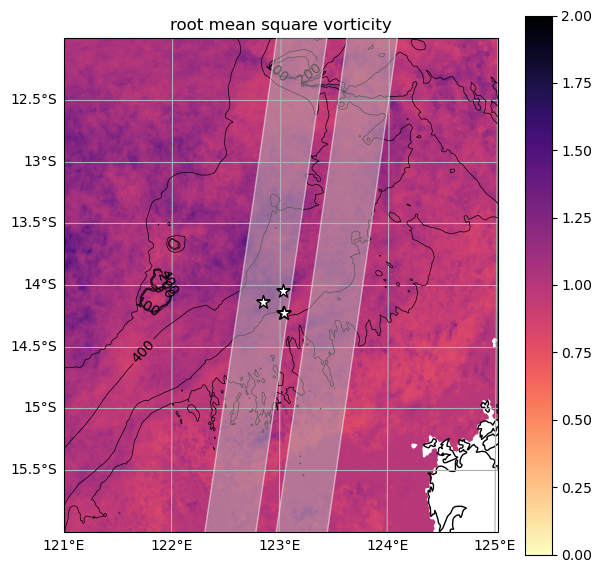

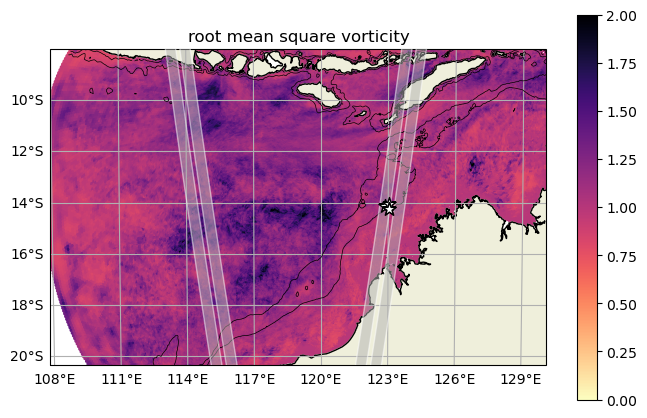

In [53]:
da = np.sqrt(ds["vorticity2_mean_full"]/ds["vorticity2_mean"])

for zoom in ["cp", "cp_large", "large"]:
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
    nwa.plot_moorings(ax)
    _, _, poly, cbar = grd.suntans.plotcelldata(da, vmin=0., vmax=2., cmap='magma_r', crs=crs)
    ax.set_title(f"ratio full time period over post initial transient")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

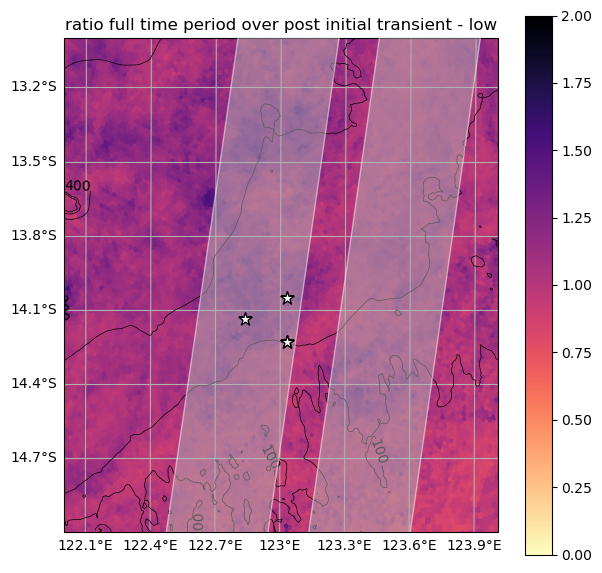

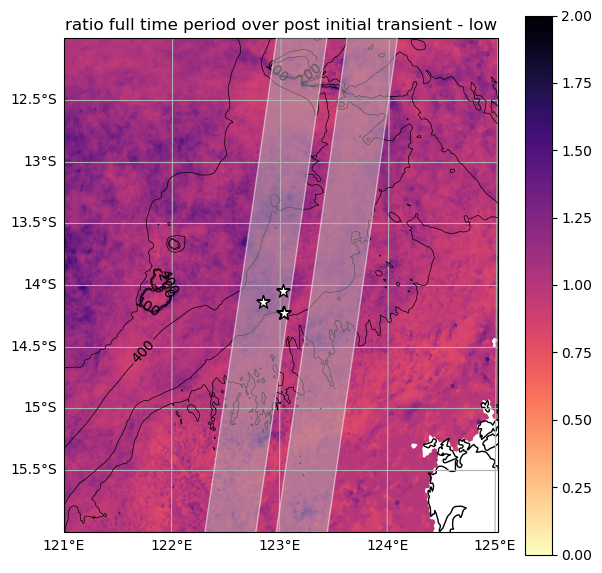

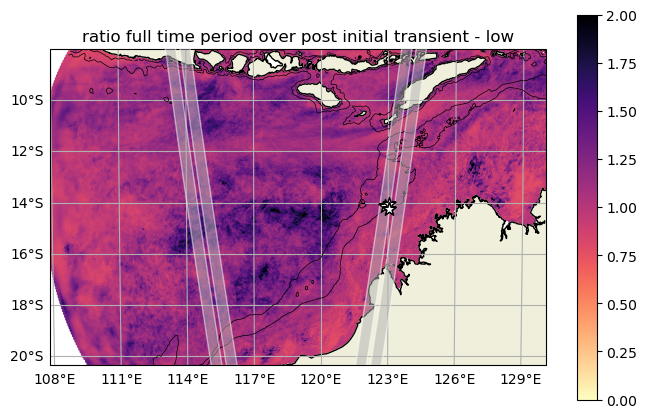

In [54]:
da = np.sqrt(ds_low["vorticity2_mean_full"]/ds_low["vorticity2_mean"])

for zoom in ["cp", "cp_large", "large"]:
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
    nwa.plot_moorings(ax)
    _, _, poly, cbar = grd.suntans.plotcelldata(da, vmin=0., vmax=2., cmap='magma_r', crs=crs)
    ax.set_title(f"ratio full time period over post initial transient - low")

---

## time series of spatially averaged enstrophy

In [33]:
E = (ds.vorticity**2).rolling(dict(time=24), center=True).mean().persist()
Elow = (ds_low.vorticity**2).rolling(dict(time=24), center=True).mean().persist()

In [43]:
areas = ["large", "cp", "cp_large", "central"]

In [60]:
grd.suntans.Ac

array([0.01223614, 0.01219859, 0.0121644 , ..., 0.00100786, 0.00085178,
       0.0012361 ])

In [68]:
def get_Ac():
    grd = nwa.load_grd()
    grd["cells"] = grd.cells.where( grd.cells!=999999, other=-999999 )
    grd.suntans.Nk = np.ones(grd.Nc.size)
    #
    nwa.project(grd)
    Ac = (xr.DataArray(grd.suntans.Ac, dims=("Nc"), name="Ac")
          .assign_coords(xv=grd.xv, yv=grd.yv)
          .chunk(dict(Nc=2000))
    )
    return Ac

Ac = get_Ac()
#Ac = nwa.load_Ac()
          
Ac

[109.00229515 109.05668874 109.11208445 ... 117.71441759 117.6852276
 117.89606311]


<xarray.DataArray 'Ac' (Nc: 225368)>
dask.array<xarray-<this-array>, shape=(225368,), dtype=float64, chunksize=(2000,), chunktype=numpy.ndarray>
Coordinates:
    xv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Dimensions without coordinates: Nc

In [69]:
zoom = nwa.zoom

def spatial_average(da, Ac, area=None):
    if area is not None:
        da = zoom(da, area)
        Ac = zoom(Ac, area)
    return (da*Ac).sum("Nc")/Ac.sum()



1.0942708004179198

In [41]:
E_tseries = dict()
Elow_tseries = dict()
for area in areas:
    _grd = nwa.zoom(grd.chunk(dict(Nc=2000)), nwa.bounds[area])
    _E = nwa.zoom(E, nwa.bounds[area])
    E_tseries[area] = (_E*_grd.Ac).sum("Nc")/_grd.Ac.sum().compute()
    _Elow = nwa.zoom(Elow, nwa.bounds[area])
    _Elow = _Elow.where(_Elow>0)
    Elow_tseries[area] = (_Elow*_grd.Ac).sum("Nc")/_grd.Ac.sum().compute()

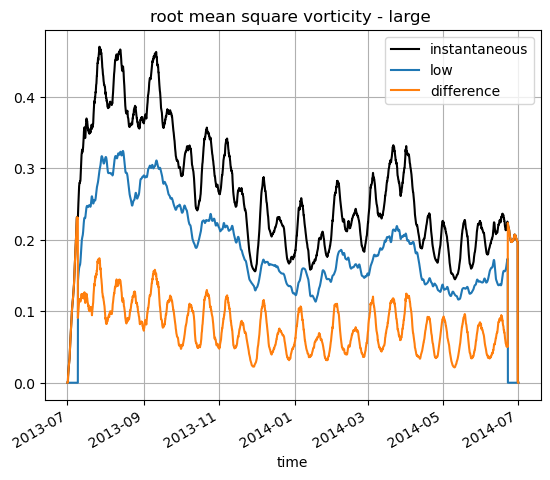

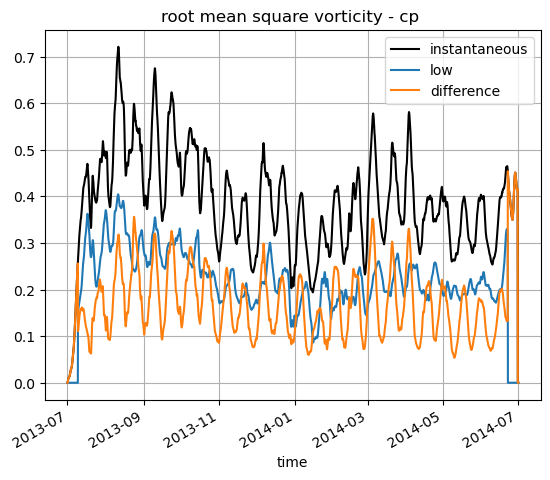

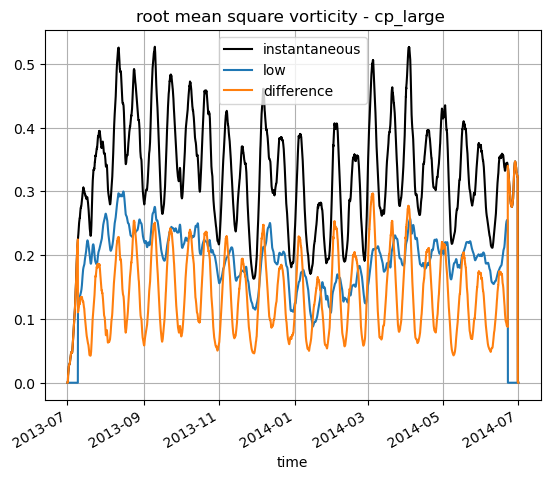

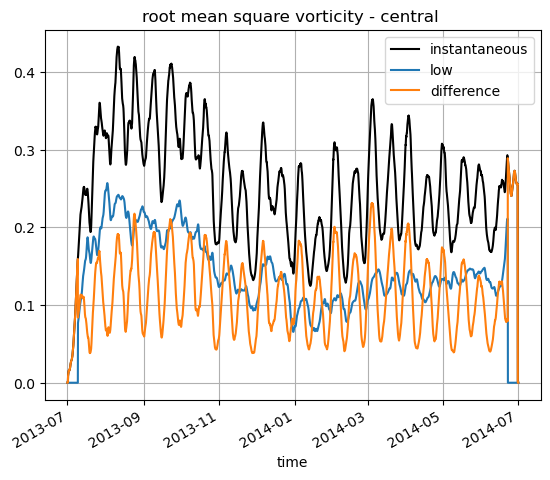

In [48]:
for area in areas:
    fig, ax = plt.subplots(1,1)
    E_tseries[area].plot(ax=ax, color="k", label="instantaneous")
    Elow_tseries[area].plot(ax=ax, label="low")
    (E_tseries[area] - Elow_tseries[area]).plot(ax=ax, label="difference")
    ax.grid()
    ax.legend()
    ax.set_title(f"root mean square vorticity - {area} ")

---

In [76]:
cluster.close()

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x2aaaf80748e0>>, <Task finished name='Task-2416181' coro=<SpecCluster._correct_state_internal() done, defined at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/distributed/deploy/spec.py:341> exception=OSError(12, 'Cannot allocate memory')>)
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/tornado/ioloop.py", line 764, in _discard_future_result
    future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/distributed/deploy/spec.py", line 441, in _close
    await self._correct_state()
  File "/home1/datahome/aponte/.miniconda3/envs/equ

OSError: [Errno 12] Cannot allocate memory